# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [1]:
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel


from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

**Read data file**

In [2]:
full_df = pd.read_csv("training_setA.csv")

## Exploratory Data Analysis

### Single and Subsample Analysis

Single case

<Axes: >

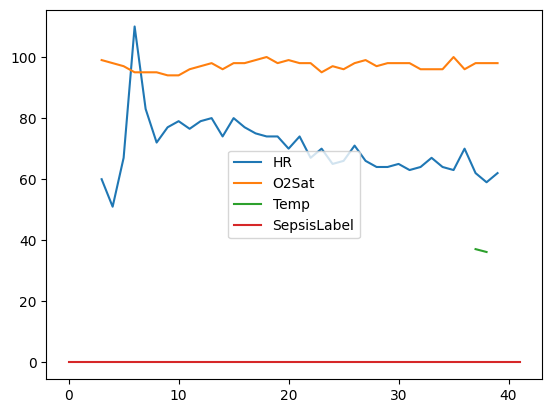

In [3]:
first_patient = full_df.loc[full_df["patient_id"]==0,["HR", "O2Sat", "Temp", "SepsisLabel"]]
first_patient.plot()

### Full Sample Analysis

Number of patiens in total and patients with sepsis

In [4]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")
     


Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

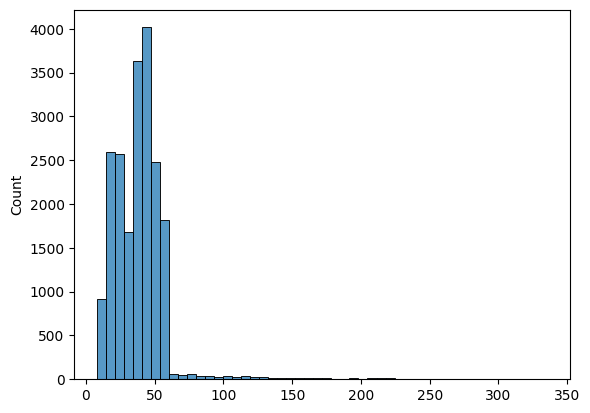

In [5]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

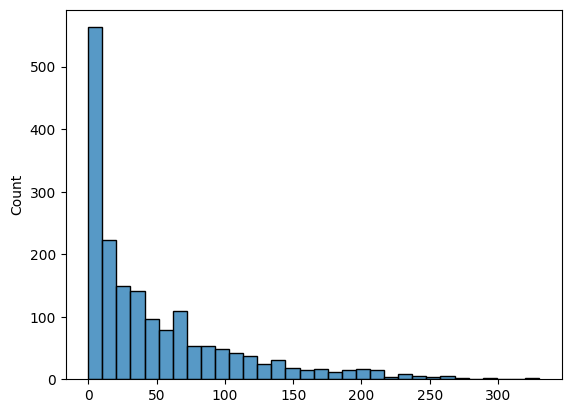

In [6]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])
  
sns.histplot(sepsis_time, kde=False);


In [7]:
# for column in full_df.columns:
    # Generate histogram for the current column
    # plt.figure()  # Create a new figure for each column
    # full_df[column].plot(kind='hist', bins=30)
    # plt.title(f'Histogram of {column}')
    # plt.xlabel(column)
    # plt.ylabel('Frequency')
    # plt.show()  # Display the histogram

In [8]:
#sns.pairplot(full_df)

## Missing Values Inspectation

In [9]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit2               0.511317
Unit1               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

## Filtering and Interpolation

Several columns have a massiv amount of missing data, i.e. less than 10% available data. Susequently, all columns with less than 10% overall data will be dropped.

In [12]:
threshold = 0.90  # Set the threshold for missing data

# Calculate the number of non-null values in each column
non_null_counts = full_df.notnull().sum()

# Calculate the percentage of missing full_df in each column
missing_percentages = 1 - (non_null_counts / len(full_df))

# Identify columns with missing data exceeding the threshold
columns_to_drop = missing_percentages[missing_percentages > threshold].index

# Drop columns with excessive missing data
full_df = full_df.drop(columns=columns_to_drop)

# Display the DataFrame after dropping columns
print("Dropped columns (less that 10% availble data):", columns_to_drop)

Dropped columns (less that 10% availble data): Index(['EtCO2', 'HCO3', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Lactate',
       'Magnesium', 'Phosphate', 'Bilirubin_total', 'TroponinI', 'Hgb', 'PTT',
       'WBC', 'Fibrinogen', 'Platelets'],
      dtype='object')


### Interpolate

Linear interpolation

In [13]:
# Forward- and backward fill missing values at the start of each patient's data
full_df_filled = full_df.groupby('patient_id', group_keys=False).apply(lambda group: group.ffill())
full_df_filled = full_df_filled.groupby('patient_id', group_keys=False).apply(lambda group: group.bfill())

In [14]:
print(full_df.shape)
print(full_df_filled.shape)

(790215, 22)
(790215, 22)


In [15]:
full_df_filled.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,...,Potassium,Hct,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.22,134.0,72.67,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.22,134.0,72.67,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,52.0,98.0,36.22,143.0,80.33,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,NaN,16.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.22,155.0,98.33,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,5,0,0


In [16]:
# Interpolate missing values within each patient's data using linear interpolation
df_int = full_df_filled.groupby('patient_id', group_keys=False).apply(lambda x: x.interpolate(method='linear'))

In [17]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,...,Potassium,Hct,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.22,134.0,72.67,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.22,134.0,72.67,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,52.0,98.0,36.22,143.0,80.33,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,NaN,16.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.22,155.0,98.33,NaN,20.0,NaN,NaN,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,5,0,0


In [18]:
df_int.columns

Index(['time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'FiO2', 'pH', 'Glucose', 'Potassium', 'Hct', 'Age',
       'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'patient_id'],
      dtype='object')

In [19]:
vars = df_int.columns
# Calculate the mean for the variables over all patients
mean_values = df_int[vars].mean()

# Iterate over the variables and fill missing values with the corresponding mean
for variable in vars:
    df_int[variable] = df_int[variable].fillna(mean_values[variable])


In [20]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,...,Potassium,Hct,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.22,134.0,72.67,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.22,134.0,72.67,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,52.0,98.0,36.22,143.0,80.33,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,60.773805,16.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.22,155.0,98.33,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,5,0,0


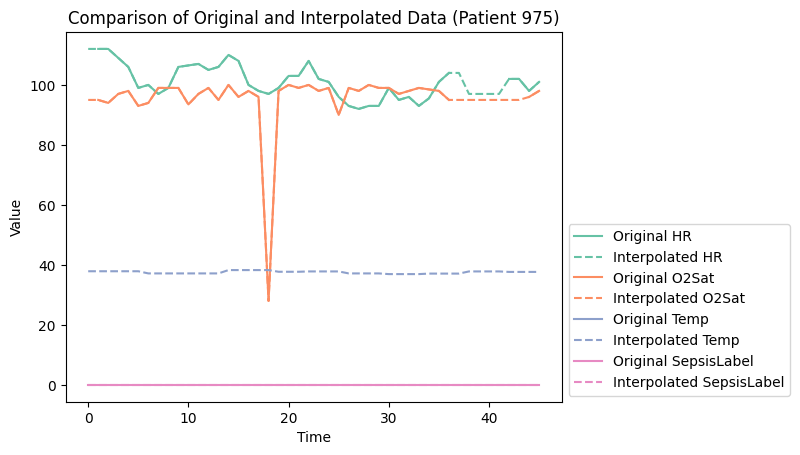

In [21]:
# Choose a specific patient for plotting (e.g., patient_id = 0)
patient_id = 975

# Specify the columns to plot
columns_to_plot = ["HR", "O2Sat", "Temp", "SepsisLabel"]

# Generate a color palette based on the number of variables
color_palette = sns.color_palette('Set2', len(columns_to_plot))

# Filter the original and interpolated data for the selected patient
original_patient_data = full_df[full_df['patient_id'] == patient_id]
interpolated_patient_data = df_int[df_int['patient_id'] == patient_id]

# Set up the figure and subplot
fig, ax = plt.subplots()

# Iterate over the columns and plot the original and interpolated data
for variable, color in zip(columns_to_plot, color_palette):
    # Plot the original data
    ax.plot(original_patient_data['time'], original_patient_data[variable], label=f'Original {variable}', color=color)

    # Plot the interpolated data
    ax.plot(interpolated_patient_data['time'], interpolated_patient_data[variable], label=f'Interpolated {variable}', linestyle='--', color=color)


# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title(f'Comparison of Original and Interpolated Data (Patient {patient_id})')

# Add legend
ax.legend(bbox_to_anchor=(1, 0.5), loc="upper left")

# Show the plot
plt.show()

## Time Series Prediction Models

### Create test and train set

In [22]:
# Optional subsample for testing

# n = 80  # Number of patients to select

# # Get unique patient IDs
# unique_patients = df_int['patient_id'].unique()

# # Select a subset of n unique patients
# selected_patients = pd.Series(unique_patients).sample(n=n, random_state=42)

# # Filter the data frame based on the selected patients and preserve the order
# df_int_subs = df_int[df_int['patient_id'].isin(selected_patients)].sort_values(by=['patient_id', 'time'])


In [23]:
df_int.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,...,Potassium,Hct,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.22,134.0,72.67,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.22,134.0,72.67,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,52.0,98.0,36.22,143.0,80.33,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,60.773805,16.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.22,155.0,98.33,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,5,0,0


In [24]:
unique_patients = df_int['patient_id'].unique()
print(unique_patients)
len(unique_patients)

[    0     1     2 ... 20333 20334 20335]


20336

In [25]:
unique_patients = df_int['patient_id'].unique()

# Split the patients into train and test sets
train_patients, test_patients = train_test_split(unique_patients, test_size=0.1, random_state=42)

# Filter the data based on the train and test patients
train_data = df_int[df_int['patient_id'].isin(train_patients)]
test_data = df_int[df_int['patient_id'].isin(test_patients)]

Check for remaining missing data

In [26]:
train_data.isnull().values.any()


False

In [27]:
test_data.isnull().values.any()

False

In [28]:
# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [29]:
features = train_data.loc[:,train_data.columns!="SepsisLabel"].columns

n_features = len(features)-1

### LSTM

#### Window Size 5

In [30]:
window_size = 5

# Define a function to create sliding windows for each patient
def create_sliding_windows(data):
    """
    Creates sliding windows of a specified size from the given data.

    Args:
        data (pandas.DataFrame): The input data from which sliding windows are created.

    Returns:
        list: A list of sliding windows, where each window is a subset of the input data.

    """
    windows = []
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i+window_size]
        windows.append(window)
    return windows

In [31]:
# Create sliding windows for each patient in the training data
train_windows = train_data.groupby('patient_id').apply(create_sliding_windows)

In [32]:
train_data.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,...,Potassium,Hct,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,52.0,98.0,36.22,134.0,72.67,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,36.22,134.0,72.67,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,52.0,98.0,36.22,143.0,80.33,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,60.773805,16.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,36.22,155.0,98.33,60.773805,20.0,0.020709,0.519688,...,3.7,36.3,76.16,0,1.0,0.0,-0.02,5,0,0


In [33]:
# Prepare training data
train_X = np.empty((0, window_size-1, n_features)) #
train_y = np.empty((0,))
for windows, patient_data in zip(train_windows, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :-1, :n_features]
    y = np.stack(windows)[:, -1, -2]
    train_X = np.concatenate((train_X, X))
    train_y = np.concatenate((train_y, y))

In [ ]:
train_y

In [ ]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y), y=train_y)
class_weights_array

In [ ]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array  ))
class_weights

In [ ]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(window_size-1, n_features)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# Train the model
model.fit(train_X, train_y, epochs=21, batch_size=32, class_weight=class_weights)

In [ ]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [ ]:
# Prepare test data
test_X = np.empty((0, window_size-1, n_features))
test_y_true = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    X = np.stack(windows)[:, :-1, :n_features]
    y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the second last column
    test_X = np.concatenate((test_X, X))
    test_y_true = np.concatenate((test_y_true, y_true))

In [ ]:
test_y_true

In [ ]:
sum(test_y_true)/len(test_y_true)

In [ ]:
# Make predictions on the test data
test_y_pred = model.predict(test_X)

# Convert predictions to binary values
test_y_pred = (test_y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(test_y_true, test_y_pred)
precision = precision_score(test_y_true, test_y_pred)
recall = recall_score(test_y_true, test_y_pred)
auc_roc = roc_auc_score(test_y_true, test_y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC Score:", auc_roc)

In [ ]:
# Compute the predicted probabilities for the positive class
test_y_pred_prob = model.predict(test_X)

# Compute the AUC-ROC score
auc_roc = roc_auc_score(test_y_true, test_y_pred_prob)

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(test_y_true, test_y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
     


Create table for results comparison

In [ ]:
# Define the window sizes
window_sizes = [5, 10]

In [ ]:
# Initialize the table to store the results
results_table = pd.DataFrame(columns=['Window Size', 'Accuracy', 'Precision', 'Recall', 'AUROC'])

In [ ]:
# Add the results to the table
results_table = results_table.append({
        'Window Size': window_sizes[0],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUROC': auc_roc
    }, ignore_index=True)

#### Window Size 10

In [ ]:
window_size = 10

In [ ]:
# Create sliding windows for each patient in the training data
train_windows_10 = train_data.groupby('patient_id').apply(create_sliding_windows)

In [ ]:
# Prepare training data
train_X_10 = np.empty((0, window_size-1, n_features)) #
train_y_10 = np.empty((0,))
for windows, patient_data in zip(train_windows_10, train_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    if len(scaled_data) > 10:
        X = np.stack(windows)[:, :-1, :n_features]
        y = np.stack(windows)[:, -1, -2]
        train_X_10 = np.concatenate((train_X_10, X))
        train_y_10 = np.concatenate((train_y_10, y))

In [ ]:
train_y_10

In [ ]:
class_weights_array = compute_class_weight(class_weight='balanced',classes=np.unique(train_y_10), y=train_y_10)
class_weights_array

In [ ]:
# Define class weights
class_weights = dict((i, weight) for i, weight in enumerate(class_weights_array))
class_weights

In [ ]:
# Define the LSTM model architecture
model_10 = Sequential()
model_10.add(LSTM(50, input_shape=(window_size-1, n_features)))
model_10.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model_10.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
# Train the model
model_10.fit(train_X_10, train_y_10, epochs=21, batch_size=32, class_weight=class_weights)

In [ ]:
# Create sliding windows for each patient in the test data
test_windows = test_data.groupby('patient_id').apply(create_sliding_windows)

In [ ]:
# Prepare test data
test_X_10 = np.empty((0, window_size-1, n_features))
test_y_true_10 = np.empty((0,))
for windows, patient_data in zip(test_windows, test_data.groupby('patient_id')):
    patient_id, scaled_data = patient_data
    if len(scaled_data) > 10:
        X = np.stack(windows)[:, :-1, :n_features]
        y_true = np.stack(windows)[:, -1, -2]  # Assuming sepsis_occurrence is the second last column
        test_X_10 = np.concatenate((test_X_10, X))
        test_y_true_10 = np.concatenate((test_y_true_10, y_true))

In [ ]:
test_y_true_10

In [ ]:
sum(test_y_true_10)/len(test_y_true_10)

In [ ]:
# Make predictions on the test data
test_y_pred_10 = model_10.predict(test_X_10)

# Convert predictions to binary values
test_y_pred_10 = (test_y_pred_10 > 0.5).astype(int)

# Evaluate the model
accuracy_10 = accuracy_score(test_y_true_10, test_y_pred_10)
precision_10 = precision_score(test_y_true_10, test_y_pred_10)
recall_10 = recall_score(test_y_true_10, test_y_pred_10)
auc_roc_10 = roc_auc_score(test_y_true_10, test_y_pred_10)

# Print evaluation metrics
print("Accuracy:", accuracy_10)
print("Precision:", precision_10)
print("Recall:", recall_10)
print("AUC-ROC Score:", auc_roc_10)

In [ ]:
test_y_pred_10.sum()

In [ ]:
# Compute the predicted probabilities for the positive class
test_y_pred_prob_10 = model_10.predict(test_X_10)

# Compute the AUC-ROC score
auc_roc_10 = roc_auc_score(test_y_true_10, test_y_pred_prob_10)

# Compute the false positive rate (FPR) and true positive rate (TPR) at different thresholds
fpr, tpr, thresholds = roc_curve(test_y_true_10, test_y_pred_prob_10)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc_10))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
     


In [ ]:
# Add the results to the table
results_table = results_table.append({
        'Window Size': window_sizes[1],
        'Accuracy': accuracy_10,
        'Precision': precision_10,
        'Recall': recall_10,
        'AUROC': auc_roc_10
    }, ignore_index=True)

## Compare Model Results

In [ ]:
# Print the results table
print(results_table)